In [1]:
#!pip list

In [2]:
# Data Loading
import json
import pandas as pd

In [3]:
# Data Cleaning and preprocessing
import numpy as np
import random
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

In [4]:
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


In [5]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [6]:
# Read data from JSON file
with open('CLINC150.json') as json_file: 
    data_dict = json.load(json_file) 

In [7]:
# Load data into respective dicts
train_data = data_dict['train']
val_data = data_dict['val']
test_data = data_dict['train'] + data_dict['test']

In [8]:
# Converting to Dataframe for sorting/filtering
train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

In [9]:
len(train_df['intent'].unique())

150

In [10]:

!pip install umap-learn
!pip install hdbscan
!pip install --upgrade pip
!pip install sentencepiece
!pip install BigBirdTokenizer
!pip install sentence-transformers
!pip install transformers
!pip install MulticoreTSNE
!pip install wordcloud

ERROR: Could not find a version that satisfies the requirement BigBirdTokenizer (from versions: none)
ERROR: No matching distribution found for BigBirdTokenizer


In [11]:
from sentence_transformers import SentenceTransformer

In [12]:
train_df

query         intent
0      what expression would i use to say i love you ...      translate
1      can you tell me how to say 'i do not speak muc...      translate
2      what is the equivalent of, 'life is good' in f...      translate
3      tell me how to say, 'it is a beautiful morning...      translate
4      if i were mongolian, how would i say that i am...      translate
...                                                  ...            ...
14995           can you explain why my card was declined  card_declined
14996  how come starbucks declined my card when i tri...  card_declined
14997        how come my card was not accepted yesterday  card_declined
14998  find out what happened to make my card get dec...  card_declined
14999                why was my card declined at safeway  card_declined

[15000 rows x 2 columns]

In [13]:
%%time
corpus=train_df['query'].values
#model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
#model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(corpus)

CPU times: user 13.4 s, sys: 2.79 s, total: 16.2 s
Wall time: 9.3 s


In [14]:
%%time
#Снижаем размерность
import umap
umap_embeddings = umap.UMAP(n_neighbors=20).fit_transform(embeddings)

CPU times: user 2min 33s, sys: 16.4 s, total: 2min 50s
Wall time: 30 s


In [15]:
%%time
#кластеризуем 
#,min_samples=5,
                          
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=100,metric='euclidean', core_dist_n_jobs=-1,                      
                          cluster_selection_method='eom',prediction_data=True).fit(umap_embeddings)



test_df

CPU times: user 871 ms, sys: 15.4 ms, total: 886 ms
Wall time: 885 ms


query         intent
0      what expression would i use to say i love you ...      translate
1      can you tell me how to say 'i do not speak muc...      translate
2      what is the equivalent of, 'life is good' in f...      translate
3      tell me how to say, 'it is a beautiful morning...      translate
4      if i were mongolian, how would i say that i am...      translate
...                                                  ...            ...
19495                     why can't i use my credit card  card_declined
19496       why won't you let me pay with my credit card  card_declined
19497                  why did i get rejected on my card  card_declined
19498              how come my credit card isn't working  card_declined
19499                            why didn't my card work  card_declined

[19500 rows x 2 columns]

In [16]:
%%time

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.5,metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
train_df['labels'] = cluster.labels_
train_df['corpus']=corpus
train_df['x']=result['x'].values
train_df['y']=result['y'].values
train_df

CPU times: user 2min 28s, sys: 21.9 s, total: 2min 49s
Wall time: 21.1 s


query         intent  \
0      what expression would i use to say i love you ...      translate   
1      can you tell me how to say 'i do not speak muc...      translate   
2      what is the equivalent of, 'life is good' in f...      translate   
3      tell me how to say, 'it is a beautiful morning...      translate   
4      if i were mongolian, how would i say that i am...      translate   
...                                                  ...            ...   
14995           can you explain why my card was declined  card_declined   
14996  how come starbucks declined my card when i tri...  card_declined   
14997        how come my card was not accepted yesterday  card_declined   
14998  find out what happened to make my card get dec...  card_declined   
14999                why was my card declined at safeway  card_declined   

       labels                                             corpus          x  \
0          20  what expression would i use to say i love you ...  -1.000696   
1          20  can you tell me how to say 'i do not speak muc...  -1.348661   
2          20  what is the equivalent of, 'life is good' in f...  -1.754880   
3          20  tell me how to say, 'it is a beautiful morning...  -1.037135   
4          16  if i were mongolian, how would i say that i am...  -0.866500   
...       ...                                                ...        ...   
14995      -1           can you explain why my card was declined  14.811245   
14996      -1  how come starbucks declined my card when i tri...  14.963156   
14997      -1        how come my card was not accepted yesterday  14.608180   
14998      -1  find out what happened to make my card get dec...  14.866011   
14999      -1                why was my card declined at safeway  14.821511   

              y  
0      0.131789  
1     -0.549883  
2     -2.171294  
3      0.296020  
4      0.315532  
...         ...  
14995  5.032497  
14996  4.900498  
14997  4.411042  
14998  4.935749  
14999  4.985581  

[15000 rows x 6 columns]

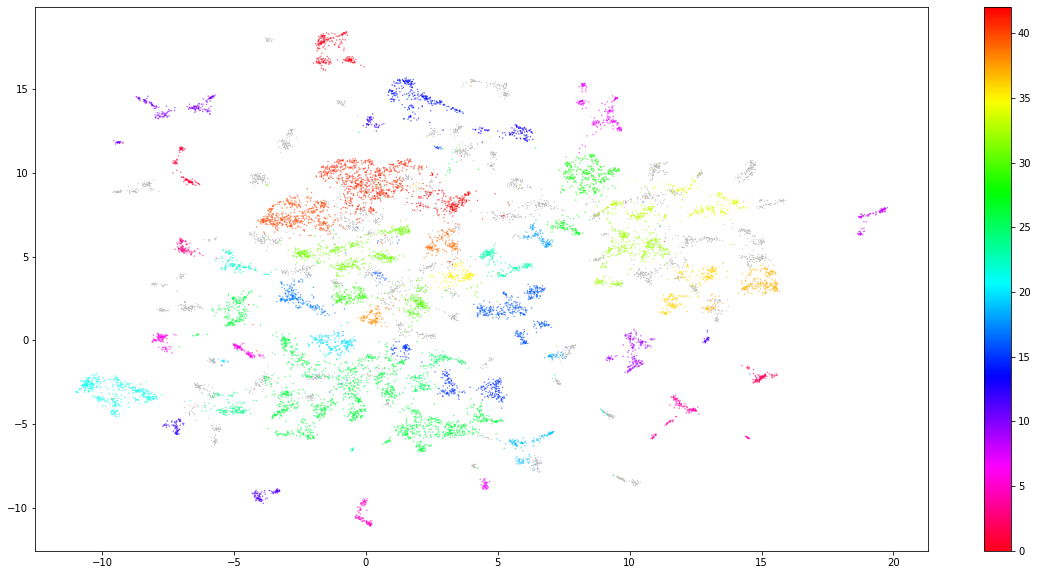

In [17]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = train_df.loc[train_df.labels == -1, :]
clustered = train_df.loc[train_df.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.1, cmap='hsv_r')
plt.colorbar()

In [18]:
train_df

query         intent  \
0      what expression would i use to say i love you ...      translate   
1      can you tell me how to say 'i do not speak muc...      translate   
2      what is the equivalent of, 'life is good' in f...      translate   
3      tell me how to say, 'it is a beautiful morning...      translate   
4      if i were mongolian, how would i say that i am...      translate   
...                                                  ...            ...   
14995           can you explain why my card was declined  card_declined   
14996  how come starbucks declined my card when i tri...  card_declined   
14997        how come my card was not accepted yesterday  card_declined   
14998  find out what happened to make my card get dec...  card_declined   
14999                why was my card declined at safeway  card_declined   

       labels                                             corpus          x  \
0          20  what expression would i use to say i love you ...  -1.000696   
1          20  can you tell me how to say 'i do not speak muc...  -1.348661   
2          20  what is the equivalent of, 'life is good' in f...  -1.754880   
3          20  tell me how to say, 'it is a beautiful morning...  -1.037135   
4          16  if i were mongolian, how would i say that i am...  -0.866500   
...       ...                                                ...        ...   
14995      -1           can you explain why my card was declined  14.811245   
14996      -1  how come starbucks declined my card when i tri...  14.963156   
14997      -1        how come my card was not accepted yesterday  14.608180   
14998      -1  find out what happened to make my card get dec...  14.866011   
14999      -1                why was my card declined at safeway  14.821511   

              y  
0      0.131789  
1     -0.549883  
2     -2.171294  
3      0.296020  
4      0.315532  
...         ...  
14995  5.032497  
14996  4.900498  
14997  4.411042  
14998  4.935749  
14999  4.985581  

[15000 rows x 6 columns]

In [19]:
#TEST

In [20]:
%%time
corpus2=test_df['query'].values
#model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
#model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings2 = model.encode(corpus2)

CPU times: user 15.3 s, sys: 2.4 s, total: 17.7 s
Wall time: 7.48 s


In [21]:
%%time
#Снижаем размерность
import umap
umap_embeddings2 = umap.UMAP(n_neighbors=20).fit_transform(embeddings2)

CPU times: user 3min 4s, sys: 22 s, total: 3min 26s
Wall time: 13.4 s


In [22]:
%%time
#кластеризуем 
#,min_samples=5,
                          
import hdbscan
cluster2 = hdbscan.HDBSCAN(min_cluster_size=100,metric='euclidean', core_dist_n_jobs=-1,                      
                          cluster_selection_method='eom').fit(umap_embeddings2)

CPU times: user 559 ms, sys: 1.02 s, total: 1.58 s
Wall time: 2.27 s


In [23]:
len(umap_embeddings2)

19500

In [26]:
%%time

import matplotlib.pyplot as plt

# Prepare data
umap_data2 = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.5,metric='cosine').fit_transform(embeddings2)
result2 = pd.DataFrame(umap_data2, columns=['x', 'y'])
test_df['labels'] = cluster2.labels_
test_df['corpus']=corpus2
test_df['x']=result2['x'].values
test_df['y']=result2['y'].values
test_df

CPU times: user 3min, sys: 23.8 s, total: 3min 24s
Wall time: 13.2 s


query         intent  \
0      what expression would i use to say i love you ...      translate   
1      can you tell me how to say 'i do not speak muc...      translate   
2      what is the equivalent of, 'life is good' in f...      translate   
3      tell me how to say, 'it is a beautiful morning...      translate   
4      if i were mongolian, how would i say that i am...      translate   
...                                                  ...            ...   
19495                     why can't i use my credit card  card_declined   
19496       why won't you let me pay with my credit card  card_declined   
19497                  why did i get rejected on my card  card_declined   
19498              how come my credit card isn't working  card_declined   
19499                            why didn't my card work  card_declined   

       labels                                             corpus         x  \
0          40  what expression would i use to say i love you ... -5.480353   
1          40  can you tell me how to say 'i do not speak muc... -6.238616   
2          40  what is the equivalent of, 'life is good' in f... -5.778020   
3          40  tell me how to say, 'it is a beautiful morning... -5.271054   
4          37  if i were mongolian, how would i say that i am... -4.959229   
...       ...                                                ...       ...   
19495      -1                     why can't i use my credit card  8.076014   
19496      -1       why won't you let me pay with my credit card  8.257764   
19497      55                  why did i get rejected on my card  8.261173   
19498      -1              how come my credit card isn't working  8.053411   
19499      -1                            why didn't my card work  7.821270   

              y  
0      0.955372  
1      0.631473  
2      1.160963  
3      0.991815  
4      0.319215  
...         ...  
19495 -4.493261  
19496 -3.996273  
19497 -3.785369  
19498 -4.436033  
19499 -4.357204  

[19500 rows x 6 columns]

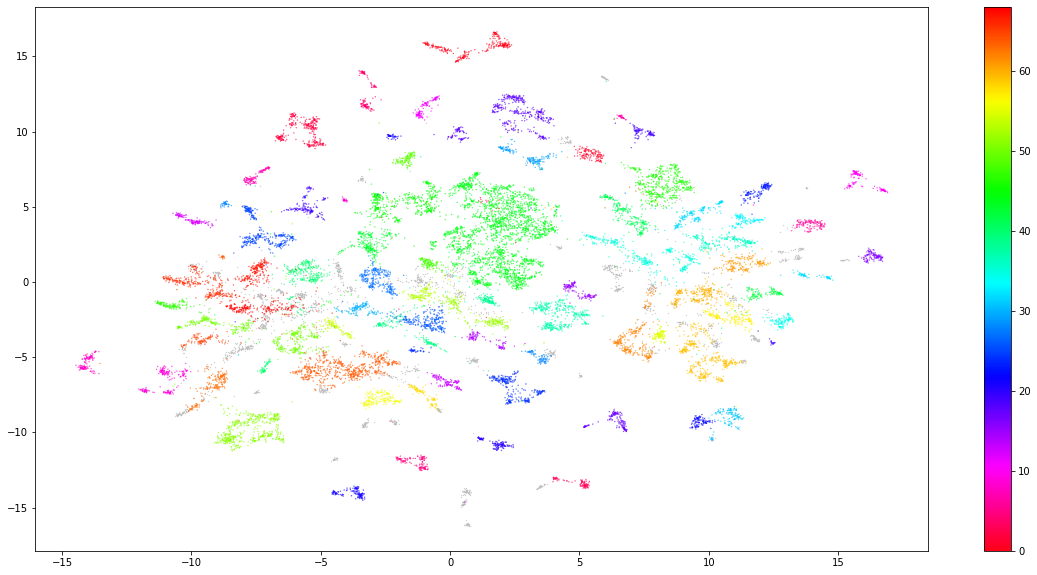

In [27]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = test_df.loc[test_df.labels == -1, :]
clustered = test_df.loc[test_df.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.1, cmap='hsv_r')
plt.colorbar()

In [ ]:
#кластерезуем по train датасету
labels, membership_strengths = hdbscan.approximate_predict(cluster, umap_embeddings2)
test_df['labels2']=labels

In [ ]:
#новые кластера, которые по первому разбиению никуда не попали бы, но во втором сформировали кластер!!!
test_df[(test_df['labels2']>0)&(test_df['labels']==-1)]